## 資料處理

In [1]:
import numpy as np
import json
import os

In [2]:
root_path="D:/DeepLearning-workplace/taiko_generate/preprocessing/audio_np"
audio_path = os.listdir(root_path)
audio_path = [ root_path+"/"+ad for ad in audio_path]

root_path="D:/DeepLearning-workplace/taiko_generate/preprocessing/map_np"
map_path = os.listdir(root_path)
map_path = [ root_path+"/"+mp for mp in map_path]

In [3]:
class data_generator:
    def __init__(self, audio_path, map_path, batch_size=64):
        self.audio_path = audio_path
        self.map_path = map_path
        self.batch_size = batch_size
        data_len=0
        self.steps=9508
#         for audio in self.audio_path:
#             audio = np.load(audio)
#             data_len+=len(audio)
#         self.steps =data_len // self.batch_size
#         if data_len % self.batch_size != 0:
#             self.steps += 1
    def __len__(self):
        return self.steps
    def __iter__(self):
        while True:
            for i, audio in enumerate(self.audio_path): #所有的音檔path
                audio = np.load(audio) #讀音檔
                f = open(self.map_path[i], "r") #讀所有的map
                maps = json.load(f)
                f.close()

                for key in maps.keys(): #讀所有難度的map
                    step=1 #紀錄batch step
                    for idx in range(0,len(audio),self.batch_size): #每次取batch_size大小的資料出來
                        if idx+self.batch_size > len(audio):
                            X = np.array(audio[idx:len(audio)]) #cnn input
                        else:
                             X = np.array(audio[idx:idx+self.batch_size])
                        C = np.zeros((len(X),5)) #condition
                        Y = np.zeros(len(X)) #output
                        C[:,int(key)]=1

                        n=0 #已被記錄過的數量
                        for t,_ in maps[key]:
                            if (t-7)>step*self.batch_size: #音檔前70ms不取
                                break
                            else:
                                Y[t-(step-1)*self.batch_size-8]=1
                                n+=1
                        for i in range(n): #把紀錄過的資料pop掉
                            maps[key].pop(0)
                        step+=1
                        yield [X, C], Y

In [4]:
# class data_generator:
#     def __init__(self, audio_path, map_path, batch_size=64):
#         self.audio_path = audio_path
#         self.map_path = map_path
#         self.batch_size = batch_size
#         data_len=0
#         #self.steps=7782
#         for audio in self.audio_path:
#             audio = np.load(audio)
#             data_len+=len(audio)
#         self.steps =data_len // self.batch_size
#         if data_len % self.batch_size != 0:
#             self.steps += 1
#     def __len__(self):
#         return self.steps
#     def __iter__(self):
#         while True:
#             for i, audio in enumerate(audio_path): #所有的音檔path
#                 audio = np.load(audio) #讀音檔
#                 f = open(map_path[i], "r") #讀所有的map
#                 maps = json.load(f)
#                 f.close()

#                 steps=len(audio)//self.batch_size
#                 for key in maps.keys(): #讀所有難度的map
#                     for _ in range(steps):
#                         t_idxs = list(range(len(maps[key])))#產生打點亂數idx
#                         np.random.shuffle(t_idxs)
#                         t_idxs=[maps[key][i][0]-8 for i in t_idxs]

#                         idxs = list(range(len(audio))) #產生亂數idx
#                         np.random.shuffle(idxs)
#                         idxs = idxs[:self.batch_size//2]

#                         Y = np.zeros(self.batch_size) #產生Y
#                         for i, idx in enumerate(idxs):
#                             if idx in t_idxs: #檢查亂數idx是否有打點
#                                 Y[i]=1
#                         Y[self.batch_size//2:]=1

#                         t_idxs=t_idxs[:self.batch_size//2]
#                         X = [audio[i] for i in idxs] #產生X
#                         for t_idx in t_idxs:
#                             X.append(audio[t_idx])
#                         X=np.array(X)

#                         C = np.zeros((self.batch_size,5)) #condition
#                         C[:,int(key)]=1

#                         yield [X, C], Y

In [3]:
t_audio_path = audio_path[:int(len(audio_path)*0.9)]
t_map_path = map_path[:int(len(map_path)*0.9)]

v_audio_path = audio_path[int(len(audio_path)*0.9):]
v_map_path = map_path[int(len(map_path)*0.9):]

print(len(t_audio_path),len(t_map_path),len(v_audio_path),len(v_map_path))

151 151 17 17


In [6]:
train_D = data_generator(t_audio_path,t_map_path,256)
print(train_D.__len__())
#valid_D =  data_generator(v_audio_path,v_map_path,256)
#print(valid_D.__len__())
# train_D = data_generator(audio_path,map_path,128)
# print(train_D.__len__())

9508


## 模型建立

In [7]:
from cond_rnn import ConditionalRNN
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, LSTM, TimeDistributed, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import ModelCheckpoint

In [8]:
inputs=Input(shape=(15,80,3))
x = Conv2D(10,(7,3),activation='relu',padding='same')(inputs)
x = MaxPooling2D(pool_size=(2,2),padding='same')(x)
x = Conv2D(20,(3,3),activation='relu',padding='same')(x)
x = MaxPooling2D(pool_size=(2,2),padding='same')(x)
x = TimeDistributed(Flatten())(x)

diffs = Input(shape=(5))
x = ConditionalRNN(200, return_sequences=True, cell='LSTM', unroll=True)([x,diffs])
x = LSTM(200,unroll=True)(x)
x = Dense(256,activation='relu')(x)
x = Dense(128,activation='relu')(x)
outputs = Dense(1,activation='sigmoid')(x)

model=Model([inputs,diffs],outputs)

In [9]:
def loss_fun(y_true, y_pred):
    return K.binary_crossentropy(y_pred,y_true)+y_true*K.binary_crossentropy(y_pred,y_true)

mc = ModelCheckpoint(
    'D:/DeepLearning-workplace/taiko_generate/StepPlacement/lstm_model_checkpoints/lstm_model{epoch:03d}-loss{loss:.3f}.h5', 
    monitor='loss', 
    save_best_only=True, 
)

In [10]:
model.compile(
    loss='binary_crossentropy',
    optimizer='sgd',
    metrics=['accuracy']
)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 15, 80, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 15, 80, 10)   640         input_1[0][0]                    
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 5)]          0                                            
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 8, 40, 10)    0           conv2d[0][0]                     
______________________________________________________________________________________________

In [11]:
history = model.fit(
    train_D.__iter__(),
    steps_per_epoch=train_D.__len__(),
    epochs=100,
    callbacks=[mc]
)
#     validation_data=valid_D.__iter__(),
#     validation_steps=valid_D.__len__(),

Epoch 1/100
9508/9508 [==============================] - 346s 36ms/step - loss: 0.1758 - accuracy: 0.9608
Epoch 2/100
9508/9508 [==============================] - 331s 35ms/step - loss: 0.1406 - accuracy: 0.9623
Epoch 3/100
9508/9508 [==============================] - 344s 36ms/step - loss: 0.1272 - accuracy: 0.9618
Epoch 4/100
9508/9508 [==============================] - 347s 37ms/step - loss: 0.1205 - accuracy: 0.9614
Epoch 5/100
9508/9508 [==============================] - 329s 35ms/step - loss: 0.1197 - accuracy: 0.9623
Epoch 6/100
9508/9508 [==============================] - 335s 35ms/step - loss: 0.1218 - accuracy: 0.9615
Epoch 7/100
9508/9508 [==============================] - 341s 36ms/step - loss: 0.1016 - accuracy: 0.9676
Epoch 8/100
9508/9508 [==============================] - 342s 36ms/step - loss: 0.1124 - accuracy: 0.9626
Epoch 9/100
9508/9508 [==============================] - 329s 35ms/step - loss: 0.1164 - accuracy: 0.9620
Epoch 10/100
9508/9508 [======================

In [12]:
model.save("D:/DeepLearning-workplace/taiko_generate/model/StepPlacement100(0602).h5")

In [13]:
import pickle
def save_history(history, fn):
    with open(fn, 'wb') as fw:
        pickle.dump(history.history, fw, protocol=2)
save_history(history,"D:/DeepLearning-workplace/taiko_generate/StepPlacement/sp_mlp_history.bin")

## 測試

In [4]:
from tensorflow import keras

In [5]:
model = keras.models.load_model("D:/DeepLearning-workplace/taiko_generate/model/StepPlacement100.h5")

In [16]:
audio0 = np.load(audio_path[1])
# audio0 = np.load("D:/DeepLearning-workplace/taiko_generate/preprocessing/audio_np/1079752 Eve - Last Dance.npy")

In [17]:
dif = np.zeros(shape=(audio0.shape[0],5))
dif[:,2]=1
result = model.predict([audio0, dif])

In [18]:
import librosa
from librosa.util import peak_pick
import matplotlib.pyplot as plt
from scipy import signal

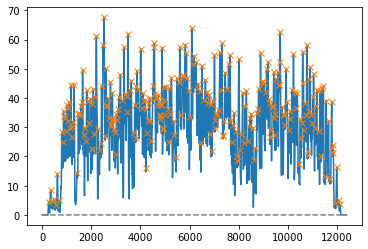

In [19]:
data = []
for r in result:
    data.append(r[0])
data=np.array(data)

data = data*1000
data = data.astype(int)

win = signal.windows.hamming(50)
x = signal.convolve(data,win,mode='same')/sum(win)

peaks, _ = signal.find_peaks(x, prominence=1)
plt.plot(x)
plt.plot(peaks, x[peaks], "x")
plt.plot(np.zeros_like(x), "--", color="gray")
plt.show()

In [20]:
peaks

array([  263,   344,   420,   493,   555,   622,   694,   801,   835,
         869,   901,   936,   972,  1000,  1037,  1071,  1105,  1138,
        1172,  1197,  1205,  1240,  1302,  1418,  1475,  1509,  1543,
        1576,  1607,  1644,  1699,  1746,  1777,  1812,  1879,  1914,
        1967,  2012,  2049,  2083,  2114,  2147,  2207,  2286,  2351,
        2381,  2417,  2485,  2518,  2564,  2587,  2612,  2620,  2665,
        2713,  2780,  2814,  2822,  2857,  2882,  2889,  2915,  2957,
        2993,  3025,  3050,  3094,  3127,  3185,  3239,  3334,  3373,
        3443,  3463,  3492,  3566,  3628,  3720,  3769,  3800,  3833,
        3864,  3902,  4013,  4068,  4107,  4129,  4186,  4219,  4241,
        4272,  4301,  4340,  4372,  4408,  4443,  4507,  4541,  4567,
        4598,  4642,  4668,  4710,  4736,  4745,  4781,  4789,  4801,
        4826,  4833,  4878,  4917,  4923,  4949,  4972,  5003,  5047,
        5115,  5147,  5183,  5216,  5261,  5348,  5387,  5433,  5484,
        5557,  5603,

In [21]:
f = open(map_path[1], "r")
# f = open("D:/DeepLearning-workplace/taiko_generate/preprocessing/map_np/1079752 Eve - Last Dance.json", "r")
maps = json.load(f)
f.close()

print(maps['2'])

[[270, 8], [337, 0], [405, 8], [539, 8], [607, 0], [674, 8], [775, 8], [809, 0], [843, 0], [876, 0], [910, 0], [944, 0], [978, 0], [1000, 0], [1011, 0], [1045, 0], [1079, 0], [1112, 0], [1146, 0], [1180, 0], [1214, 0], [1247, 0], [1281, 0], [1303, 0], [1315, 0], [1416, 8], [1438, 8], [1450, 8], [1483, 4], [1517, 8], [1551, 0], [1562, 0], [1584, 8], [1607, 8], [1618, 0], [1652, 0], [1674, 0], [1685, 0], [1708, 8], [1719, 8], [1753, 12], [1775, 0], [1787, 8], [1809, 8], [1820, 0], [1832, 0], [1854, 8], [1876, 8], [1888, 0], [1921, 0], [1944, 0], [1955, 0], [1978, 8], [1989, 8], [2000, 8], [2023, 4], [2090, 0], [2101, 0], [2124, 8], [2146, 8], [2157, 0], [2191, 0], [2214, 0], [2225, 0], [2247, 8], [2258, 8], [2292, 12], [2315, 0], [2326, 8], [2348, 0], [2360, 0], [2371, 8], [2393, 0], [2416, 8], [2427, 0], [2461, 0], [2483, 0], [2494, 0], [2517, 8], [2528, 8], [2551, 8], [2562, 0], [2596, 8], [2618, 8], [2629, 8], [2652, 8], [2674, 0], [2697, 0], [2719, 8], [2742, 0], [2787, 8], [2832, 0]

In [22]:
realMilSecs = list()
for ele in maps['2']:
    realMilSecs.append(ele[0])
    
realMilSecs

[270,
 337,
 405,
 539,
 607,
 674,
 775,
 809,
 843,
 876,
 910,
 944,
 978,
 1000,
 1011,
 1045,
 1079,
 1112,
 1146,
 1180,
 1214,
 1247,
 1281,
 1303,
 1315,
 1416,
 1438,
 1450,
 1483,
 1517,
 1551,
 1562,
 1584,
 1607,
 1618,
 1652,
 1674,
 1685,
 1708,
 1719,
 1753,
 1775,
 1787,
 1809,
 1820,
 1832,
 1854,
 1876,
 1888,
 1921,
 1944,
 1955,
 1978,
 1989,
 2000,
 2023,
 2090,
 2101,
 2124,
 2146,
 2157,
 2191,
 2214,
 2225,
 2247,
 2258,
 2292,
 2315,
 2326,
 2348,
 2360,
 2371,
 2393,
 2416,
 2427,
 2461,
 2483,
 2494,
 2517,
 2528,
 2551,
 2562,
 2596,
 2618,
 2629,
 2652,
 2674,
 2697,
 2719,
 2742,
 2787,
 2832,
 2865,
 2888,
 2899,
 2921,
 2944,
 2966,
 2989,
 3011,
 3034,
 3056,
 3079,
 3101,
 3135,
 3157,
 3169,
 3202,
 3225,
 3247,
 3270,
 3292,
 3337,
 3360,
 3382,
 3405,
 3427,
 3450,
 3472,
 3494,
 3506,
 3573,
 3596,
 3607,
 3641,
 3663,
 3674,
 3697,
 3708,
 3730,
 3742,
 3775,
 3798,
 3809,
 3843,
 3865,
 3876,
 3899,
 3910,
 3933,
 3955,
 3978,
 4000,
 4023,
 4079

In [32]:
# 取出實際map之節拍毫秒值
realMiliSecs = list()
for ele in maps['2']:
    realMiliSecs.append(ele[0])

# 誤差區間值
DET_RANGE = 10
# 計算TP, FP, FN score以得出精準度
tpScore, fpScore, fnScore, previousRealMiliSecs, hitFlag = 0, 0, 0, 0, False
for guessMiliSecs in peaks:
    # 取得與猜測時間點最近的實際時間點
    closestRealMiliSecs = min(realMiliSecs, key = lambda x:abs(x-guessMiliSecs))
    if previousRealMiliSecs != closestRealMiliSecs:
        if not hitFlag:
            fnScore += 1
        hitFlag = False
    print([closestRealMiliSecs, guessMiliSecs])
    if (closestRealMiliSecs - 7) + DET_RANGE > guessMiliSecs > (closestRealMiliSecs - 7) - DET_RANGE:
        print('hit')
        tpScore += 1
        hitFlag = True
    else:
        fpScore += 1
    previousRealMiliSecs = closestRealMiliSecs

F_measure = 2 * tpScore / (2 * tpScore + fpScore + fnScore)
print([tpScore, fpScore, fnScore])
print(F_measure)


[270, 263]
hit
[337, 344]
[405, 420]
[539, 493]
[539, 555]
[607, 622]
[674, 694]
[809, 801]
hit
[843, 835]
hit
[876, 869]
hit
[910, 901]
hit
[944, 936]
hit
[978, 972]
hit
[1000, 1000]
hit
[1045, 1037]
hit
[1079, 1071]
hit
[1112, 1105]
hit
[1146, 1138]
hit
[1180, 1172]
hit
[1180, 1197]
[1214, 1205]
hit
[1247, 1240]
hit
[1303, 1302]
hit
[1416, 1418]
hit
[1483, 1475]
hit
[1517, 1509]
hit
[1551, 1543]
hit
[1584, 1576]
hit
[1607, 1607]
hit
[1652, 1644]
hit
[1708, 1699]
hit
[1753, 1746]
hit
[1775, 1777]
hit
[1809, 1812]
[1876, 1879]
[1921, 1914]
hit
[1978, 1967]
hit
[2023, 2012]
hit
[2023, 2049]
[2090, 2083]
hit
[2124, 2114]
hit
[2146, 2147]
hit
[2214, 2207]
hit
[2292, 2286]
hit
[2348, 2351]
[2371, 2381]
[2416, 2417]
hit
[2483, 2485]
hit
[2517, 2518]
hit
[2562, 2564]
hit
[2596, 2587]
hit
[2618, 2612]
hit
[2618, 2620]
hit
[2674, 2665]
hit
[2719, 2713]
hit
[2787, 2780]
hit
[2832, 2814]
[2832, 2822]
hit
[2865, 2857]
hit
[2888, 2882]
hit
[2888, 2889]
hit
[2921, 2915]
hit
[2966, 2957]
hit
[2989, 

In [4]:
from tensorflow import keras
import librosa
from librosa.util import peak_pick
import matplotlib.pyplot as plt
from scipy import signal

In [5]:
model = keras.models.load_model("D:/DeepLearning-workplace/taiko_generate/StepPlacement/lstm_model_checkpoints/lstm_model097-loss0.078.h5")

In [12]:
F_measure_list=[]
for i,ap in enumerate(v_audio_path):
    audio=np.load(ap)
    f = open(v_map_path[i], "r") #讀所有的map
    maps = json.load(f)
    f.close()
    
    for key in maps.keys():
        
        dif = np.zeros(shape=(audio.shape[0],5))
        dif[:,int(key)]=1
        result = model.predict([audio, dif])

        data = []
        for r in result:
            data.append(r[0])
        data=np.array(data)

        data = data*1000
        data = data.astype(int)

        win = signal.windows.hamming(50)
        x = signal.convolve(data,win,mode='same')/sum(win)

        peaks, _ = signal.find_peaks(x, prominence=6-int(key))
        
        
        
        # 取出實際map之節拍毫秒值
        realMiliSecs = list()
        for ele in maps[key]:
            realMiliSecs.append(ele[0])

        # 誤差區間值
        DET_RANGE = 10
        # 計算TP, FP, FN score以得出精準度
        tpScore, fpScore, fnScore, previousRealMiliSecs, hitFlag = 0, 0, 0, 0, False
        for guessMiliSecs in peaks:
            # 取得與猜測時間點最近的實際時間點
            closestRealMiliSecs = min(realMiliSecs, key = lambda x:abs(x-guessMiliSecs))
            if previousRealMiliSecs != closestRealMiliSecs:
                if not hitFlag:
                    fnScore += 1
                hitFlag = False
            #print([closestRealMiliSecs, guessMiliSecs])
            if (closestRealMiliSecs - 8) + DET_RANGE > guessMiliSecs > (closestRealMiliSecs - 8) - DET_RANGE:
                #print('hit')
                tpScore += 1
                hitFlag = True
            else:
                fpScore += 1
            previousRealMiliSecs = closestRealMiliSecs

        F_measure = 2 * tpScore / (2 * tpScore + fpScore + fnScore)
        F_measure_list.append(F_measure)
        print(F_measure)

0.6771653543307087
0.5882352941176471
0.6523297491039427
0.5185185185185185
0.6033519553072626
0.4723618090452261
0.5752508361204013
0.5308641975308642
0.5860113421550095
0.7310789049919485
0.5227963525835866
0.6112759643916914
0.7567567567567568
0.6896551724137931


KeyboardInterrupt: 

In [ ]:
print(sum(F_measure_list)/len(F_measure_list))

In [21]:
#epoch:100 F-measure:0.6533429545336129  0.6623983055946281
#change loss epoch:100 F-measure:0.6516763914260577
#batch with half true half false epoch:100 F-measure: 0.5912396110843625
#CLSTM MLP F-measure: 0.6383143191978708
#CLSTM MLP F-measure(best loss):0.6614476859666824

#CLSTM MLP 150 data acc:0.6408024720950587  vacc: 0.6383143191978708
#CLSTM MLP 150 data(best loss) vacc: 0.6507261690213612